## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

In [1]:
# Imports here
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import random
import numpy as np
import matplotlib.pyplot as plt


### 1. Read in the data.

In [2]:
ckd = pd.read_csv('./chronic_kidney_disease_full.csv')
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: 

I'd like to see how the classes are balanced first and formost. 

Then, I'd like to find a way to take care of the null values in a non destructive manner, and identify if anything is missing so much so that it may not be usefull.  

Check the distribution of variables and identify if features have importance or are simply non predictive.

Next, I'll check for correlations between ckd and the other features to identify what may be important or not. 

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [3]:
ckd.isnull().sum() # It looks like every column is missing something except for our target .

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.  
**Note:** You can clean your data below in step 4 when building a model!

In [4]:
ckd.shape

(400, 25)

In [5]:
copy_of_ckd = ckd.dropna()
copy_of_ckd.shape

(158, 25)

In [6]:
(400-158)/400

0.605

Answer: 

This would be terrible. We would lose a lot of our data! In fact we go from 400 to 158 rows. This is a loss of over 60% of the data and it is already a small dataset. (1. we severly limit the amount of data we use and we throw out a lot of potentially usefull information. 2.NA could  mean something in many of these columns and discarding them may be removing an entire features usefullness.)

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer: 

Human error can be a factor as unfortunate as that can be, patients could be mixed up or the data incorectly recorded. 

Some of the data may be subjective if it is nominal and one doctor/patient may have different view point of something such as appetite, or if something is abnormal.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a "model" where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: We could tell everyone that they have it, but that's a pretty bad practice. 

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:

We optimized sensitivity so we had no false negatives. A false negative would be a actual positive case that was incorrectly predicted and that would be bad in this medical instance. 

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer:

Telling everyone they have CKD is a disadvantage because the model is no good at determining what actually makes a difference in if someone has CKD. It also can create a lot of anxiety in patients in which they may lose faith in the medical process if everyone is incorrectly dignosed. May cost a lot of money to treat CKD that is unnessesarily spent in the case of false positives. 

### 9. Suppose that I want to construct a "model" where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: Tell everyone that they do not have CKD. Also a terrible option but fufills the above task of no false positives. 

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We optimized the specificity by minimizing the false positives. 

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: This is unethical because now we will have a lot of false negatives and many people that have CKD will go undiagnosed. If CKD is a serious health concern it will be disasterous for many people's livelyhood. I'd say this is even worse than diagnosing everyone because many people will be at risk and potentially die! Also the model is pretty much pointless because it does no detection. 

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint 1: Remember to do a train/test split!  
> Hint 2: This will require data cleaning first!

In [7]:
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [8]:
ckd['target'] = [1 if i == 'ckd' else 0 for i in ckd['class']]
ckd.target.value_counts()

1    250
0    150
Name: target, dtype: int64

Now we have the target variable as a binary numerical. Next let us create an interaction term with potentially correlated terms. 
1. Pus cell and Pus Cell Clumps
2. White Blood Cell Count and Red Blood Cell Count.

In [9]:
ckd['pc_pcc_interaction'] = [1 if ckd.loc[i, 'pc'] == 'abnormal'
                             and ckd.loc[i, 'pcc'] == 'present'
                             else 0 for i in range(len(ckd['pc']))]

In [10]:
ckd['wbcc_rbcc_interaction'] = ckd['wbcc'] * ckd['rbcc']

Interactions are now created in the dataframe. Now we must dummify all the nominal parameters. 

In [11]:
ckd.dtypes

age                      float64
bp                       float64
sg                       float64
al                       float64
su                       float64
rbc                       object
pc                        object
pcc                       object
ba                        object
bgr                      float64
bu                       float64
sc                       float64
sod                      float64
pot                      float64
hemo                     float64
pcv                      float64
wbcc                     float64
rbcc                     float64
htn                       object
dm                        object
cad                       object
appet                     object
pe                        object
ane                       object
class                     object
target                     int64
pc_pcc_interaction         int64
wbcc_rbcc_interaction    float64
dtype: object

In [17]:
ckd_dummified =  pd.get_dummies(ckd, drop_first=True)
ckd_dummified.head().T

,0,1,2,3,4
age,48.00,7.00,62.00,48.000,51.00
bp,80.00,50.00,80.00,70.000,80.00
sg,1.02,1.02,1.01,1.005,1.01
al,1.00,4.00,2.00,4.000,2.00
su,0.00,0.00,3.00,0.000,0.00
bgr,121.00,NaN,423.00,117.000,106.00
bu,36.00,18.00,53.00,56.000,26.00
sc,1.20,0.80,1.80,3.800,1.40
sod,NaN,NaN,NaN,111.000,NaN
pot,NaN,NaN,NaN,2.500,NaN


In [18]:
ckd_dummified.drop(columns=['class_notckd'], inplace=True)
# Droping the unessesary target variable (already got a target one)

NULL VALUES ARE PREVENTING THE MODEL FROM GOING FORWARD.
GOING TO FILL ALL NULLS WITH THE MEAN OF THEIR RESPECTIVE COLUMN. 
WARNING: NOT GOOD PRACTICE


In [33]:
for col in ckd_dummified.columns:
    ckd_dummified[str(col)].fillna( ckd_dummified[str(col)].mean(), 
                                  inplace=True)

In [34]:
ckd_dummified.isnull().sum()

age                      0
bp                       0
sg                       0
al                       0
su                       0
bgr                      0
bu                       0
sc                       0
sod                      0
pot                      0
hemo                     0
pcv                      0
wbcc                     0
rbcc                     0
target                   0
pc_pcc_interaction       0
wbcc_rbcc_interaction    0
rbc_normal               0
pc_normal                0
pcc_present              0
ba_present               0
htn_yes                  0
dm_yes                   0
cad_yes                  0
appet_poor               0
pe_yes                   0
ane_yes                  0
dtype: int64

Okay We have everything we need, ALl the parameters are included and accounted for. Next we should create a Standard scaler and train-test-split this data set up. Lets do it! 

Important to note that regularization depends on the scale of the features so we must scale it! I do it out of good habbit but its important whenever we do a l1 or l2 regularization. (LASSO and Ridge).

In [35]:
ss = StandardScaler() # initializing the SS

In [81]:
X = ckd_dummified.drop(columns=['target'])
y = ckd_dummified['target']
X_scaled = ss.fit_transform(X)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                   test_size = 0.2, 
                                                   random_state = 42)

Okay lets do a gridsearched model over Ridge and LASSO models, class weights as normal or balanced, and differing C values. 

In [83]:
params = {'C': [0.001, 0.01, 0.1, 1, 10],
              'class_weight': [None, 'balanced'],
              'penalty': ['l1', 'l2']}

lr = LogisticRegression(solver='liblinear',
                       max_iter = 1000, 
                       random_state=42)
# We are testing l1 and l2 penalties in GridSearch.
# The default solver 'lbfgs' only supports l2, 
# so we're switching to 'liblinear' instead.

gs = GridSearchCV(estimator= lr,
                 param_grid=params,
                 scoring='recall', 
#recall is the metric we want to optimize
                 cv = 5).fit(X_train, y_train)

In [84]:
gs.best_estimator_

LogisticRegression(C=10, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [85]:
gs.best_estimator_.get_params()

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [78]:
gs.best_score_

1.0

In [79]:
gs.score(X_test, y_test)

1.0

Okay so our GS is great but we need the individual model to get the coefficients out. 

In [95]:
logreg = LogisticRegression(solver='liblinear', 
                           max_iter=1000, 
                           C =10, 
                           class_weight='balanced',
                           penalty = 'l2',
                           random_state=42)

In [96]:
logreg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

In [97]:
print(f' Training score : {logreg.score(X_train, y_train)}')
print(f' Testing score : {logreg.score(X_test, y_test)}')

 Training score : 1.0
 Testing score : 0.9875


---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [102]:
list(zip(np.exp(logreg.coef_[0]) , X.columns))

[(0.6193456906658227, 'age'),
 (2.8065286066714714, 'bp'),
 (0.126110072455217, 'sg'),
 (5.392977223606017, 'al'),
 (1.155574723495205, 'su'),
 (2.7790044913712975, 'bgr'),
 (0.5870156498526645, 'bu'),
 (2.6915443517513116, 'sc'),
 (0.4100884962566631, 'sod'),
 (1.0956095893501088, 'pot'),
 (0.11773108338147711, 'hemo'),
 (0.46952460819351005, 'pcv'),
 (1.1475899222243862, 'wbcc'),
 (0.336152793547641, 'rbcc'),
 (0.6997577378914587, 'pc_pcc_interaction'),
 (1.1894041216918751, 'wbcc_rbcc_interaction'),
 (0.08731394698702374, 'rbc_normal'),
 (1.1337111697131557, 'pc_normal'),
 (1.1416980172499411, 'pcc_present'),
 (0.9117166865418183, 'ba_present'),
 (2.5136264444978638, 'htn_yes'),
 (3.0913604913762533, 'dm_yes'),
 (0.6213955267963308, 'cad_yes'),
 (3.17930040323004, 'appet_poor'),
 (2.8884183083576094, 'pe_yes'),
 (0.9865048865020395, 'ane_yes')]

As al-albumin increases by 1 unit (scaled however in this instance... We could rerun the model unscaled but it would lose accuracy.) the chances of getting a positive test result increase by 5.39. In this list it apears to be the strongest correlation. 

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

Pedal Edema (pe) has a 'scaled' 2.89 correlation. So when a patient 
has a yes on PE then there is a 2.89 increase in the chance that the
patient has ckd. 

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer: 

Logistical Regression allows the reader of the model to intrepret the coefficients and figure out the feature importance. 

Usually does not end up very overfit compared to other models. 

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Think about which data is used for model evaluation. Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [103]:
y_preds = logreg.predict(X_test)

It makes more sence to create a confusion matrix on our testing data because we want to determine effective our model is on new data, rather than on the data that created the model. 

In [104]:
confusion_matrix(y_test, y_preds)

array([[27,  1],
       [ 0, 52]], dtype=int64)

In [105]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [108]:
print('True Negatives: ' +str(tn) )
print('False Positives: '+str(fp) )
print('False Negatives: '+str(fn) )
print('True Positives: ' +str(tp) )

True Negatives: 27
False Positives: 1
False Negatives: 0
True Positives: 52


### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: 

We want to optimize both if we can. Focusing only on sensitivity will give us to many false positives. Focusing only on specificity will give us false negatives and that will have ckd positives slip through and we cannot have that. So sensitivity is more important in this case but we should be working to optimize both. A combination of the sensitivity and specificity is called an f-1 score and we should optimize that. 

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [109]:
#Taken from solution from Charlie.


def roc(probas, true, step=0.01):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    """
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
         
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange")
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show();

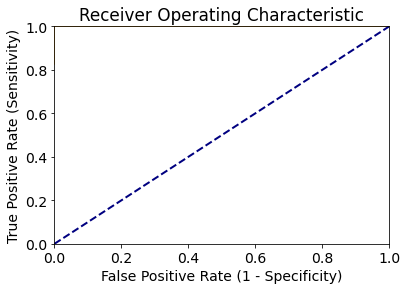

In [111]:
probabilities = logreg.predict_proba(X_test)

roc(probas = probabilities, # pass in series of probabilities 
    true = y_test,          # pass in series of true values
    step=0.001);            # pass in step size

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer:

Unbalanced classes can be an issue because the model may have a hard time learning the minority class. In this case having balanced cases in the gridsearch does improve the model, but a 40/60 split is not a very significant difference. 

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer:

Sometimes things are complicated, and a patient has odd symptoms or a combination of problems. You may not have enough information to determine the root causes or recommed treatments because of a flood of other information. Having an abundance of knoledge that is unhelpful may fog the view for the diagnosis, and this is what happens when we have unbalanced classes. 


### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!). The [`pandas .sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method may be _very_ useful here!
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with just over 200,000 observations, of which only about 0.075% are non-CKD individuals.

In [112]:
ckd_dummified['target'].value_counts()

1    250
0    150
Name: target, dtype: int64

In [113]:
ckd_unbalanced = ckd_dummified[ckd_dummified['target'] == 1].sample(200_000, 
                                                                   replace=True,
                                                                   random_state=42)

In [115]:
ckd_joined = pd.concat([ckd_dummified, ckd_unbalanced])

In [118]:
ckd_joined['target'].value_counts(normalize=True)

1    0.999251
0    0.000749
Name: target, dtype: float64

### 22. What do you expect will be the impact of unbalanced classes on your logistic regression model?

**Answer:**

I have a feeling the accuracy is going to be great , but the specificity will not be great and we will have a lot of false positives.

### 23. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. 
> Be sure to look at how well it performs on non-CKD data.

In [122]:
X = ckd_joined.drop(columns=['target'])
y = ckd_joined['target']

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.3,
                                                   random_state = 42)

In [124]:
logreg

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

In [127]:
logreg_2 = LogisticRegression(solver='liblinear',
                             max_iter = 1000,
                             C=10,
                             random_state = 42, 
                             penalty = 'l2')
logreg_2.fit(X_test, y_test)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [129]:
y_preds = logreg_2.predict(X_test)
confusion_matrix(y_test, y_preds)

array([[   54,     2],
       [    0, 60064]], dtype=int64)

In [131]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print("True Negatives: " + str(tn))
print("False Positives: " + str(fp))
print("False Negatives: " + str(fn))
print("True Positives: " + str(tp))

True Negatives: 54
False Positives: 2
False Negatives: 0
True Positives: 60064


### 24. Do the results of your model above align with your expectations of the impact of unbalanced classes on logistic regression? If not, do you have any thoughts on why your model, considering the data, is performing how it is?

**Answer:**

I still have no false negatives so I'd say we created a pretty good model. A couple false positives but by in large this worked out great. Much rather have a couple false positives than a couple negatives.  

---

## Step 6: Answer the problem. (Nothing to do here...except think about it!)

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!